# Predicting Earthquake damage to buildings 

# Importing Libraries

In [0]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Loading

In [0]:
# path has been removed to maintain privacy
X = pd.read_csv('/train_values_RP.csv',index_col='building_id')

In [0]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# path has been removed to maintain privacy
Y= pd.read_csv('/train_labels_RP.csv', index_col='building_id')

In [0]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [0]:
# path has been removed to maintain privacy
test = pd.read_csv('/test_values_RP.csv', index_col='building_id')

In [0]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# EDA

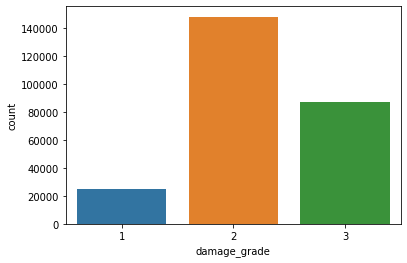

In [0]:
sns.countplot(Y['damage_grade'])

# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [0]:
fea = pd.merge(X, Y, on='building_id')

In [0]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

In [0]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [0]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [0]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

In [0]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [0]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [0]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

In [0]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [0]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [0]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [0]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [0]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [0]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [0]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [0]:
onehot = OneHotEncoder(sparse=False)

In [0]:
onehot.fit(inp)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [0]:
inp.shape

(694938, 1)

In [0]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [0]:
l1_hot = onehot.transform(l1)

In [0]:
l1_hot.shape

(347469, 1419)

In [0]:
l2_hot = onehot.transform(l2)

In [0]:
l2_hot.shape

(347469, 1419)

In [0]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [0]:
l3_hot = np.array(pd.get_dummies(l3))

In [0]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [0]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(20, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1419)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                115200    
_________________________________________________________________
dense (Dense)                (None, 11861)             249081    
Total params: 364,281
Trainable params: 364,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
modelf.fit(fin_inp, l3_hot, epochs=10, batch_size=64)

Epoch 1/10
5430/5430 [==============================] - 33s 6ms/step - loss: 0.0185
Epoch 2/10
5430/5430 [==============================] - 33s 6ms/step - loss: 8.3740e-04
Epoch 3/10
5430/5430 [==============================] - 34s 6ms/step - loss: 8.3151e-04
Epoch 4/10
5430/5430 [==============================] - 33s 6ms/step - loss: 8.3096e-04
Epoch 5/10
5430/5430 [==============================] - 33s 6ms/step - loss: 8.2794e-04
Epoch 6/10
5430/5430 [==============================] - 33s 6ms/step - loss: 7.9378e-04
Epoch 7/10
5430/5430 [==============================] - 32s 6ms/step - loss: 7.5802e-04
Epoch 8/10
5430/5430 [==============================] - 33s 6ms/step - loss: 7.3332e-04
Epoch 9/10
5430/5430 [==============================] - 33s 6ms/step - loss: 7.0521e-04
Epoch 10/10
5430/5430 [==============================] - 32s 6ms/step - loss: 6.7878e-04


### Getting the relation vector from the output of intermediate layer

In [0]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [0]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [0]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [0]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [0]:
geo_fea_train = inter.predict(fin_inp)

<font size=3>**Test**</font>

In [0]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [0]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [0]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [0]:
geo_fea_test = inter.predict(fin_inp)

# Final  Data

In [0]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 20), test (86868, 20)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [0]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [0]:
fx_tr.shape

(260601, 94)

In [0]:
test.fillna(value=0, inplace=True)

In [0]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 94)

In [0]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

# Applying machine learning

#### Random Forest

In [0]:
param = {'n_estimators': [ 500, 1000],
    'min_samples_split':[20, 50, 500]}

In [0]:
clf = RandomForestClassifier()

In [0]:
gd_sr = GridSearchCV(estimator=clf,
                     param_grid=param,
                     scoring='f1_micro',
                     cv=5,
                     n_jobs=-1)

In [0]:
gd_sr.fit(fx_tr, fy_tr)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
gd_sr.best_score_

0.7578366869270473

In [0]:
gd_sr.best_params_

{'min_samples_split': 20, 'n_estimators': 1000}

# Result

#### taking the best parameters and predicting our result for test dataset

In [0]:
fin_clf = RandomForestClassifier(min_samples_split=20, n_estimators=1000)

In [0]:
fin_clf.fit(fx_tr, fy_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
results = fin_clf.predict(fx_te)

In [0]:
# path has been removed to maintain privacy
submission_format = pd.read_csv('submission_format_RP.csv', index_col='building_id')

In [0]:
sub_2804 = pd.DataFrame(results, columns=submission_format.columns, index=submission_format.index)

In [0]:
sub_2804.to_csv('sub8_2804.csv')